In [7]:
import sys
import os
import time
import warnings
sys.path.append(os.path.abspath(os.path.join('../../')))
warnings.filterwarnings("ignore")

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from evaluation import full_evaluate

In [9]:
# Reading the dataset
df = pd.read_csv("../../datasets/final_features_dataset.csv")

# Separating features and target variable
X = df.drop(columns=['is_fraud', 'Unnamed: 0'])
y = df['is_fraud']

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Convert data to arrays if they are not already
X_train = X_train.values if isinstance(X, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y, pd.Series) else y_train

In [10]:
# Defining the hyperparameter search space
hyperparameter_space = {
    "criterion": [0, 3],
    "splitter": [-1, 1],
    "max_depth": [1, 30],
    "min_samples_split": [2, 20],
    "min_samples_leaf": [1, 20],
    "min_weight_fraction_leaf": [0, 0.5],
    "max_features": [1, 50],
    "max_leaf_nodes": [2, 50],
    "min_impurity_decrease": [0, 1],
    "class_weight": [-1, 1],
    "ccp_alpha": [0, 10]
}

# Define fitness function to evaluate model performance
def fitness(hyperparameters, get_model = False):
    """
    Function to evaluate the fitness of decision tree model with given hyperparameters.

    Args:
    hyperparameters (list): List of hyperparameter values.
    get_model (bool): If True, returns the model only, otherwise returns the fitness score.

    Returns:
    float or DecisionTreeClassifier: Fitness score if get_model=False, else the model itself.
    """
    # Check if hyperparameters are within defined ranges
    for i, value in enumerate(hyperparameters):
        param_name = list(hyperparameter_space.keys())[i]
        range_min = hyperparameter_space[param_name][0]
        range_max = hyperparameter_space[param_name][1]
        if not (range_min <= value <= range_max):
            return float('-inf') # Penalize if hyperparameters are out of range
    
    # Determine criterion
    criterion = "gini"
    if int(hyperparameters[0]) == 2:
        criterion = "entropy"
    elif int(hyperparameters[0]) == 3:
        criterion = "log_loss"

    # Determine splitter
    splitter = "best"
    if int(hyperparameters[1]) > 0:
        splitter = "random"
    
    # Create decision tree model with specified hyperparameters
    model = DecisionTreeClassifier(
        criterion = criterion,
        splitter = splitter,
        max_depth = round(hyperparameters[2]),
        min_samples_split = round(hyperparameters[3]),
        min_samples_leaf = round(hyperparameters[4]),
        min_weight_fraction_leaf = hyperparameters[5],
        max_features = round(hyperparameters[6]),
        max_leaf_nodes = round(hyperparameters[7]),
        min_impurity_decrease = hyperparameters[8],
        class_weight = "balanced" if hyperparameters[9]>0 else None,
        ccp_alpha = abs(hyperparameters[10]),
        random_state=0,
    )

    # If only model is requested, return the model
    if get_model:
        print('Best parameters', {
            "criterion": criterion,
            "splitter": splitter,
            "max_depth": round(hyperparameters[2]),
            "min_samples_split": round(hyperparameters[3]),
            "min_samples_leaf": round(hyperparameters[4]),
            "min_weight_fraction_leaf": hyperparameters[5],
            "max_features": round(hyperparameters[6]),
            "max_leaf_nodes": round(hyperparameters[7]),
            "min_impurity_decrease": hyperparameters[8],
            "class_weight": "balanced" if hyperparameters[9]>0 else None,
            "ccp_alpha": abs(hyperparameters[10])
        })
        return model
    else:
        # Initialize cross-validation
        cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
        cv_results = []

        # Perform cross-validation
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            
            # smote oversampling
            sm = RandomUnderSampler()
            X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)
            
            # Fit the model
            model = model.fit(X_train_fold, y_train_fold)
            
            # Make predictions
            y_train_pred = model.predict(X_train_fold)
            y_test_pred = model.predict(X_test_fold)
            
            # Calculate evaluation metrics
            f1_train = f1_score(y_train_fold, y_train_pred)
            f1_test = f1_score(y_test_fold, y_test_pred)

            # Store results
            cv_results.append({'f1_train': f1_train, 'f1_test': f1_test})
        
        # Extracting F1 scores for training, testing, and validation sets from cross-validation results
        f1_train = np.array([fold["f1_train"] for fold in cv_results])
        f1_test = np.array([fold["f1_test"] for fold in cv_results])

        # Initialize the score variable to negative infinity
        score = float("-inf")
        # Check if the standard deviation of the mean F1 scores across training, testing, and validation sets is less than 0.01
        if np.array([f1_test.mean(), f1_train.mean()]).std()<0.02:
            # If the condition is met, set the score to the mean F1 score of the validation set
            score = f1_test.mean()
        return score

New best 0.0
New best 0.9235172327830002


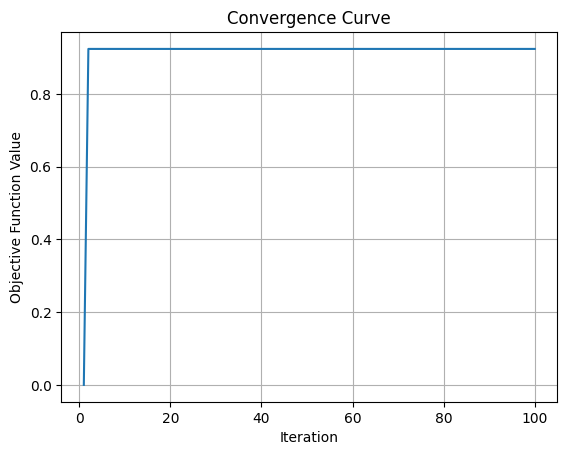

Best parameters {'criterion': 'gini', 'splitter': 'best', 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.3383082604504736, 'max_features': 30, 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.0, 'class_weight': 'balanced', 'ccp_alpha': 0.0}
Training set Counter({0: 396, 1: 396}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 396, 1: 396}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 396, 1: 396}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 396, 1: 396}) Test set Counter({0: 2926, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Fold 1: (Train F1: 0.93, Test F1: 0.92, Validation F1: 0.90, Precision: 1.00, Recall: 0.83, Accuracy: 0.99).
Fold 2: (Train F1: 0.92, Test F1: 0.93, Validation F1: 0.90, Precision: 1.00, Recall: 0.83, Accuracy: 0.99).
Fold 3: (Train F1: 0.92, T

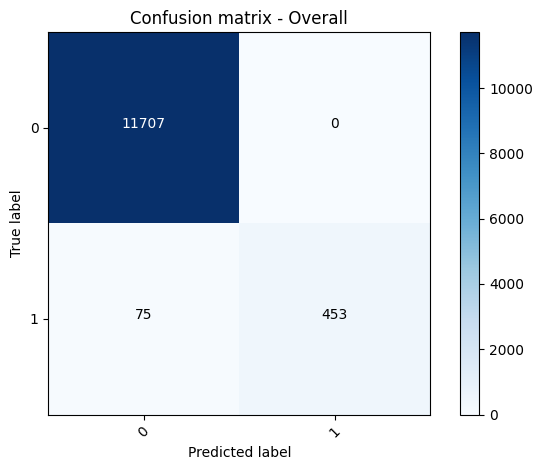

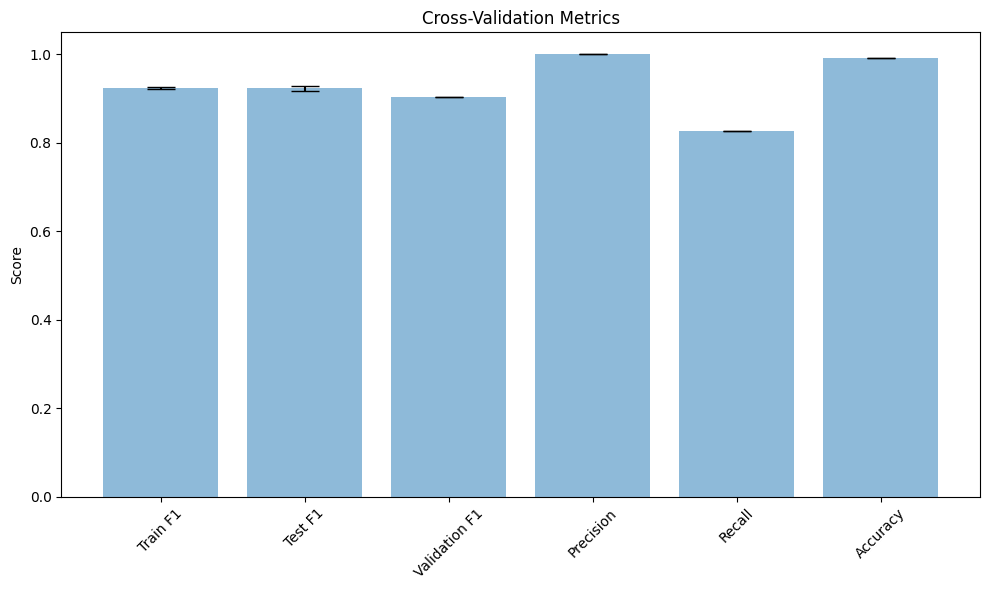

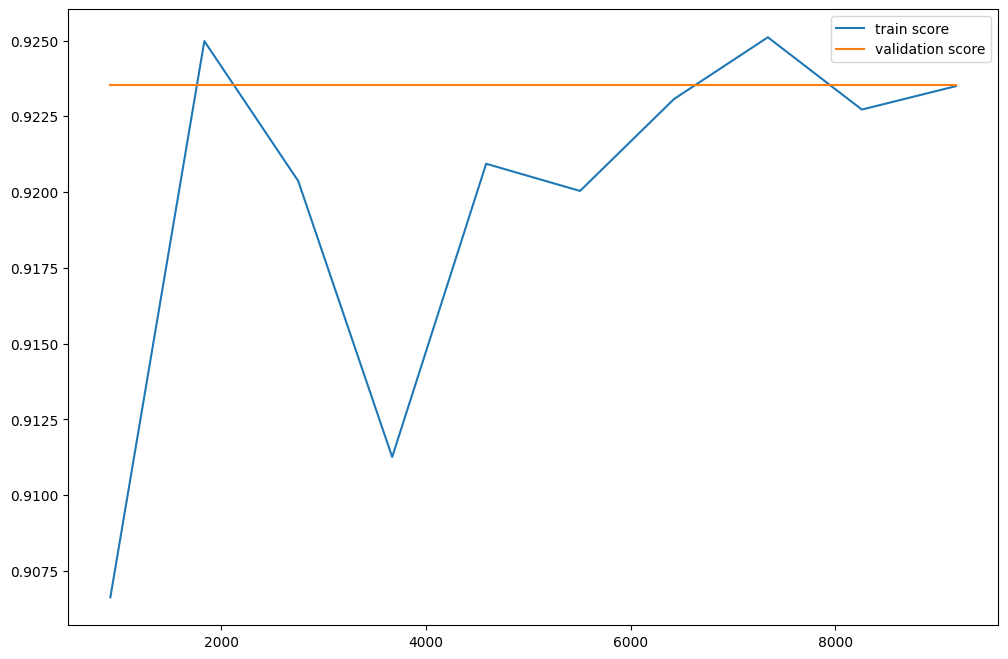

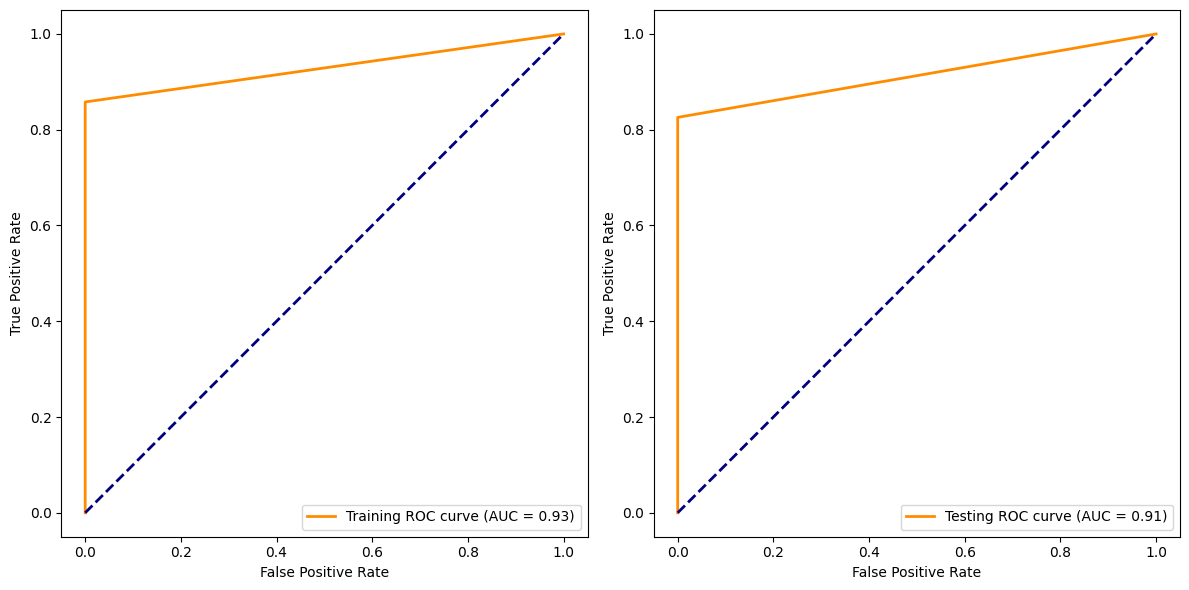

20.60947823524475 seconds


In [11]:
# Measure the start time for the optimization process
starting = time.time()

# Perform hyperparameter optimization using the Harris Hawks Optimization algorithm
# The `full_evaluate` function evaluates the fitness of each individual (hawk) in the population
# by calling the `fitness` function defined earlier
# `fitness` is the function that computes the fitness score for each set of hyperparameters
# `X` is the feature dataset
# `y` is the target variable
# `hyperparameter_space` defines the search space for hyperparameters
# `sampling` is an optional parameter to specify the sampling method
# `max_iter` specifies the maximum number of iterations for the HHO algorithm
# `pop_size` specifies the population size for each iteration
full_evaluate.full_evaluate(fitness, X, y, hyperparameter_space, sampling='under', max_iter=100, pop_size=5)

# Measure the time taken for optimization by calculating the difference between the start time and the current time
exec_time = time.time() - starting

# Print the execution time in seconds
print(exec_time, "seconds")